In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

### Reading the Data

In [2]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/aclImdb/')

In [3]:
tr_d = text_dataset_from_directory( w_dir / 'train' )
va_d = text_dataset_from_directory( w_dir / 'validation' )
te_d = text_dataset_from_directory( w_dir / 'test' )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# Config to get sequence of int
text_vectorization = layers.TextVectorization( 
    max_tokens=20000,
    output_mode='int',
    output_sequence_length=600
)

In [5]:
text_only = tr_d.map( lambda x, y: x )

text_vectorization.adapt( text_only )

In [6]:
tr_d_emb = tr_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )
va_d_emb = va_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )
te_d_emb = te_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )

In [7]:
tr_d_emb = tr_d_emb.prefetch( buffer_size=tf.data.AUTOTUNE )
va_d_emb = va_d_emb.prefetch( buffer_size=tf.data.AUTOTUNE )
te_d_emb = te_d_emb.prefetch( buffer_size=tf.data.AUTOTUNE )

### The model

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
with strategy.scope():
    inputs = keras.Input(shape=(None,), dtype='int64')
    
    embedded = layers.Embedding(input_dim=20000, output_dim=256, mask_zero=True)(inputs)
    
    x = layers.Bidirectional( layers.LSTM(32) )(embedded)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense( 1, activation='sigmoid' )(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile( 
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'embeding.keras',
        save_best_only=True,
        monitor='accuracy'
    ),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d_emb.cache(),
    epochs=16,
    validation_data=va_d_emb.cache(),
    callbacks=callbacks
)

Epoch 1/16
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:b

In [11]:
model_test = keras.models.load_model('embeding.keras')

print(f"Accuracy: {model_test.evaluate(te_d_emb)[1]:.3f}")

782/782 [==============================] - 29s 34ms/step - loss: 0.8877 - accuracy: 0.8539
Accuracy: 0.854


### Ploting Training

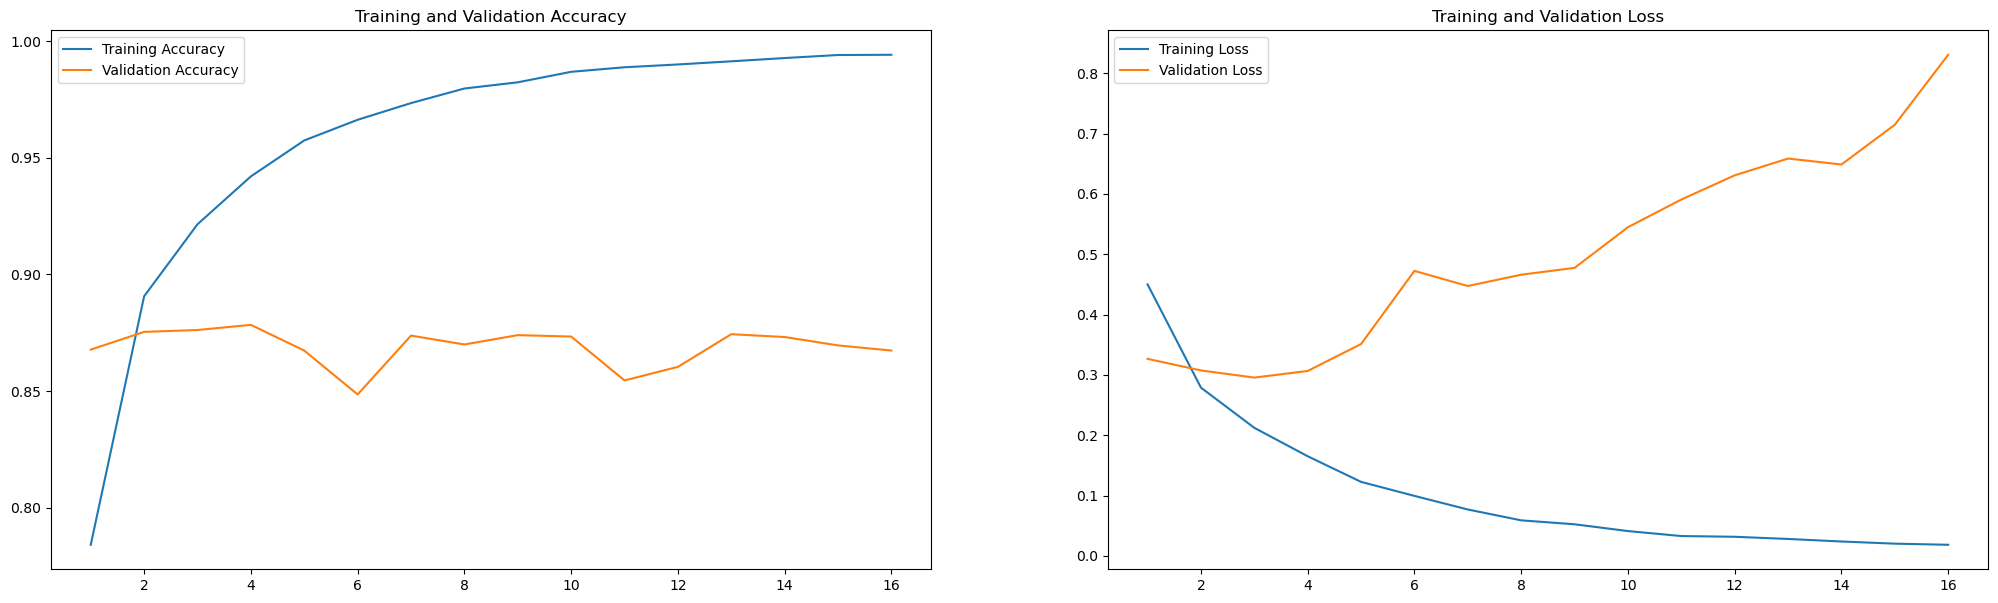

In [12]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range( 1, len(accuracy) + 1 )

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot( epochs, accuracy, label='Training Accuracy' )
ax[0].plot( epochs, val_acc, label='Validation Accuracy' )
ax[0].set_title('Training and Validation Accuracy' )
ax[0].legend()

ax[1].plot( epochs, loss, label='Training Loss' )
ax[1].plot( epochs, val_loss, label='Validation Loss' )
ax[1].set_title( 'Training and Validation Loss' )
ax[1].legend();